In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
import torch.optim as optim

In [3]:
# IMU-Based Energy Expenditure Estimation for Various Walking Conditions Using a Hybrid CNN–LSTM Model
# conv1d(64, 3)
# maxpooling1d(64, 3)
# 2 LSTM 64 hidden units
# flatten layer
# fully connected layer
# output

In [2]:
# class SimpleDataset:
def SimpleDataset(person, weight, attempt, time_steps, num_data):
    all_data = []

    for p in range(1, person + 1):
        for w in range(1, weight + 1):
            for a in range(1, attempt + 1):

                imu_data = torch.tensor((w+1)*10*np.random.rand(1, time_steps, num_data))
                emg_data = torch.mean(imu_data) / 40
                if emg_data > 1:
                  emg_data = 1

                all_data.append((imu_data, emg_data))

    return all_data

num_person = 1000
num_weights = 5
num_attempt = 50
time_steps = 100
num_data = 15
dataset = SimpleDataset(num_person, num_weights, num_attempt, time_steps, num_data)

In [4]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_data, out_channels=64, kernel_conv=1, kernel_pool=1, hidden_lstm=64, layers_lstm=1):
        super(CNN_LSTM, self).__init__()
        self.batch_size = batch_size

        # Linear layer
        self.linear1 = nn.Linear(time_steps*num_data, num_data)

        # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=num_data, out_channels=64, kernel_size=kernel_conv).double()

        # Max Pooling Layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_pool).double()

        # LSTM layers
        self.lstm = nn.LSTM(out_channels, hidden_lstm, layers_lstm, batch_first=True).double()

        # Fully connected layer for regression
        self.fc1 = nn.Linear(out_channels, 1).double() # Output dimension is 1 for regression

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1e-1)
                nn.init.zeros_(m.bias)

    def forward(self, x): # shape (batch_size, 1, time_steps, num_data) = (2, 1, 100, 15)
        x = x.view(batch_size, -1) # shape (batch_size, 1*time_steps*num_data) = (2, 150)
        x = self.linear1(x.float()) # shape (batch_size, 1*num_data) = (2, 15)
        x = x.view(batch_size, 1, 15) # shape (batch_size, 1, 1, num_data) = (2, 1, 15)
        x = F.relu(x) # shape (batch_size, num_sensors, 1, num_data) = (2, 1, 15)

        x = x.double()
        x = x.permute(0, 2, 1) # shape (batch_size, num_data, num_sensors) = (2, 15, 1)
        x = self.conv1(x) # shape (batch_size, out_channels, _) = (2, 64, 1)
        x = self.pool1(x) # shape (batch_size, out_channels, 1) = (2, 64, 1)
        x = F.relu(x) # shape (batch_size, out_channels, 1) = (2, 64, 1)

        x = x.squeeze(2) # shape (batch_size, out_channels) = (2, 64)
        x, _ = self.lstm(x) # shape (batch_size, out_channels) = (2, 64)

        x = self.fc1(x).float() # shape (batch_size, 1) = (2, 1)
        output = x.squeeze(1) # shape (batch_size) = (2)
        return output

In [5]:
import sys
def train(model, train_loader, time_steps, criterion, optimizer, epochs=5, batch_size=1):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        print('-----------EPOCH %d-----------' % (epoch + 1))
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.float()
            labels = labels.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 1225 == 0:
                print('[episode: %d] loss: %f' % (i + 1, running_loss / 1225))
                losses.append(running_loss / 1225)
                running_loss = 0.0
    print(outputs, labels)
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

def test(model, test_loader, batch_size=1):
    model.eval()
    total_error = 0
    total_batches = 0
    total_error2 = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            total_batches += 1
            batch_error = torch.abs(outputs.flatten() - labels.flatten()) / labels.flatten()
            batch_error2 = torch.abs(outputs.flatten() - labels.flatten())
            total_error += batch_error.mean().item()
            total_error2 += batch_error2.mean().item()
            if (i + 1) % 1225 == 0:
                print(outputs, labels)
    print('Average accuracy: %f %% ' % (100 - total_error / total_batches * 100))
    print('Average error between prediction and label: %f' % (total_error2 / total_batches))

In [62]:
data, label = dataset[0]
data_list = []
label_list = []
for i in range(len(dataset)):
  data, label = dataset[i]
  data_list.append(data)
  label_list.append(label)

num_rows = len(data_list)
indices = torch.randperm(num_rows).tolist()
shuffled_data = [data_list[i] for i in indices]
shuffled_labels = [label_list[i] for i in indices]

shuffled_dataset = (shuffled_data, shuffled_labels)

In [58]:
print(shuffled_dataset[1][1])

tensor(0.3814, dtype=torch.float64)


In [59]:
# @title Testo del titolo predefinito
# data, labels = dataset[:, :]
# num_rows = data.shape[0]
# indices = torch.randperm(num_rows)
# shuffled_data = data[indices]
# shuffled_labels = labels[indices]
# shuffled_dataset = shuffled_data, shuffled_labels

# data, label = dataset[:]

batch_size = 10

train_set = [(shuffled_data[i], shuffled_labels[i]) for i in range(np.int64(len(dataset)/2))]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = [(shuffled_data[i], shuffled_labels[i]) for i in range(np.int64(len(dataset)/2), len(dataset))]
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# train_set = [(dataset[i]) for i in range(np.int64(len(dataset)/2))]
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# test_set = [(dataset[i]) for i in range(np.int64(len(dataset)/2), len(dataset))]
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


-----------EPOCH 1-----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[episode: 250] loss: 0.045099
[episode: 500] loss: 0.032675
[episode: 750] loss: 0.030983
[episode: 1000] loss: 0.029277
[episode: 1250] loss: 0.027650
[episode: 1500] loss: 0.027405
[episode: 1750] loss: 0.025097
[episode: 2000] loss: 0.024279
[episode: 2250] loss: 0.022670
[episode: 2500] loss: 0.020405
[episode: 2750] loss: 0.018294
[episode: 3000] loss: 0.016883
[episode: 3250] loss: 0.015407
[episode: 3500] loss: 0.013977
[episode: 3750] loss: 0.012436
[episode: 4000] loss: 0.010978
[episode: 4250] loss: 0.010205
[episode: 4500] loss: 0.009517
[episode: 4750] loss: 0.008662
[episode: 5000] loss: 0.007998
[episode: 5250] loss: 0.007376
[episode: 5500] loss: 0.007304
[episode: 5750] loss: 0.006963
[episode: 6000] loss: 0.007086
[episode: 6250] loss: 0.006393
[episode: 6500] loss: 0.005761
[episode: 6750] loss: 0.006111
[episode: 7000] loss: 0.005486
[episode: 7250] loss: 0.005113
[episode: 7500] loss: 0.005073
[episode: 7750] loss: 0.005102
[episode: 8000] loss: 0.005087
[episode: 8

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[episode: 12500] loss: 0.002744
-----------EPOCH 2-----------
[episode: 250] loss: 0.002763
[episode: 500] loss: 0.002354
[episode: 750] loss: 0.002555
[episode: 1000] loss: 0.002412
[episode: 1250] loss: 0.002410
[episode: 1500] loss: 0.002483
[episode: 1750] loss: 0.002408
[episode: 2000] loss: 0.002347
[episode: 2250] loss: 0.002466
[episode: 2500] loss: 0.002016
[episode: 2750] loss: 0.002324
[episode: 3000] loss: 0.002296
[episode: 3250] loss: 0.002090
[episode: 3500] loss: 0.001949
[episode: 3750] loss: 0.001960
[episode: 4000] loss: 0.002057
[episode: 4250] loss: 0.001986
[episode: 4500] loss: 0.001779
[episode: 4750] loss: 0.001909
[episode: 5000] loss: 0.001827
[episode: 5250] loss: 0.001878
[episode: 5500] loss: 0.001915
[episode: 5750] loss: 0.001711
[episode: 6000] loss: 0.001597
[episode: 6250] loss: 0.001710
[episode: 6500] loss: 0.001743
[episode: 6750] loss: 0.001762
[episode: 7000] loss: 0.001673
[episode: 7250] loss: 0.001629
[episode: 7500] loss: 0.001650
[episode: 7

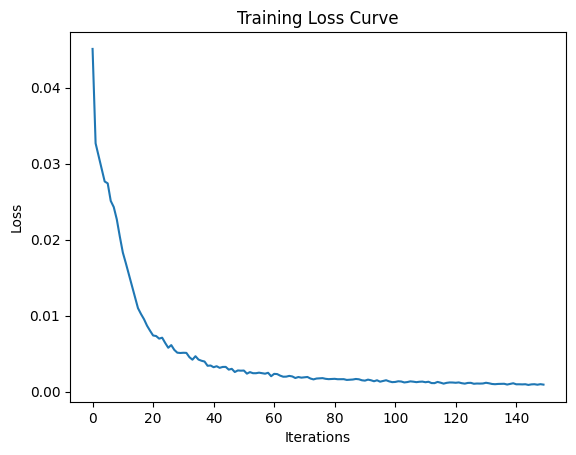

In [60]:
model = CNN_LSTM(num_data, layers_lstm=2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, train_loader, time_steps, criterion, optimizer, epochs=3, batch_size=batch_size)

In [61]:
test(model, test_loader, batch_size=batch_size)

tensor([0.4619, 0.5611, 0.3904, 0.2428, 0.4942, 0.7490, 0.4022, 0.7616, 0.5013,
        0.6916]) tensor([0.5019, 0.6242, 0.3693, 0.2504, 0.4992, 0.7302, 0.3777, 0.7595, 0.4836,
        0.7348], dtype=torch.float64)
tensor([0.2425, 0.3840, 0.7096, 0.3827, 0.3903, 0.5492, 0.2345, 0.2357, 0.4902,
        0.2293]) tensor([0.2471, 0.3883, 0.7631, 0.3802, 0.3819, 0.4933, 0.2515, 0.2510, 0.5187,
        0.2524], dtype=torch.float64)
tensor([0.5391, 0.5115, 0.3745, 0.4695, 0.5106, 0.7149, 0.6680, 0.2239, 0.2308,
        0.5001]) tensor([0.4979, 0.5092, 0.3732, 0.5030, 0.5168, 0.7534, 0.6190, 0.2440, 0.2511,
        0.5076], dtype=torch.float64)
tensor([0.7152, 0.3882, 0.3644, 0.6239, 0.3836, 0.2272, 0.7714, 0.5969, 0.2519,
        0.3543]) tensor([0.7401, 0.3801, 0.3672, 0.6252, 0.3749, 0.2462, 0.7572, 0.6062, 0.2483,
        0.3710], dtype=torch.float64)
tensor([0.6441, 0.6277, 0.4384, 0.4735, 0.2472, 0.5467, 0.7599, 0.3910, 0.2261,
        0.2198]) tensor([0.6311, 0.6314, 0.5054, 0.4958, 0.2